In [1]:
import fastf1
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from fastf1.ergast import Ergast
from sklearn.metrics import mean_absolute_error, mean_squared_error
pd.set_option('display.float_format', '{:.3f}'.format)

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
#sess = fastf1.get_session(2023, 'Abu Dhabi Grand Prix', 'R')
#sess.load()

In [2]:
df_all = pd.read_csv('/Users/macbook/Documents/fastf1/race_data/race_data_2018_2023.csv')
df_all.info()

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_25134/2430009690.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv('/Users/macbook/Documents/fastf1/race_data/race_data_2018_2023.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136062 entries, 0 to 136061
Data columns (total 34 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Time                136062 non-null  object 
 1   Driver              136062 non-null  object 
 2   DriverNumber        136062 non-null  int64  
 3   LapTime             133354 non-null  float64
 4   LapNumber           136062 non-null  float64
 5   Stint               135719 non-null  float64
 6   PitOutTime          4367 non-null    float64
 7   PitInTime           4513 non-null    float64
 8   Sector1Time         133111 non-null  float64
 9   Sector2Time         135757 non-null  float64
 10  Sector3Time         135625 non-null  float64
 11  Sector1SessionTime  132789 non-null  object 
 12  Sector2SessionTime  135757 non-null  object 
 13  Sector3SessionTime  135625 non-null  object 
 14  SpeedI1             116594 non-null  float64
 15  SpeedI2             135705 non-nul

In [3]:
def preprocess_data(df, map_compound=True, map_teams=False):
    # Create a copy of the input DataFrame
    df_copy = df.copy()

    # If needed map the old team names to the 2023 ones
    if map_teams:
      team_name_mapping = {
         'Force India': 'Aston Martin',
         'Racing Point': 'Aston Martin',
         'Toro Rosso': 'AlphaTauri',
         'Sauber': 'Alfa Romeo',
         'Alfa Romeo Racing': 'Alfa Romeo',
         'Renault': 'Alpine'
      }
      # Replace the old team names with the new ones in the 'Team' column
      df_copy['Team'] = df_copy['Team'].replace(team_name_mapping)

    if map_compound:
      compound_mapping = {
         'HYPERSOFT':1,'ULTRASOFT':2, 'SUPERSOFT':3, 'SOFT':4,
         'MEDIUM':5,'HARD':6, 'INTERMEDIATE':7, 'WET':8, 'UNKNOWN':0
      }
      
      df_copy['Compound'] = df_copy['Compound'].fillna('UNKNOWN')
      df_copy['Compound'] = df_copy['Compound'].replace(compound_mapping)
      
   

    df_copy['TrackStatus'] = df_copy['TrackStatus'].astype(str)
    df_copy['PitIn'] = df_copy['PitInTime'].notnull()
    df_copy['PitOut'] = df_copy['PitOutTime'].notnull()
    

    df_copy = df_copy.drop(['Time','PitInTime','PitOutTime','Sector1SessionTime','Sector2SessionTime', 'Sector3SessionTime','LapStartTime',
       'LapStartDate','Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate'], axis=1)

    # Return the preprocessed DataFrame
    return df_copy

In [4]:
df_all = preprocess_data(df_all, map_compound=True)

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_25134/832340770.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy['Compound'] = df_copy['Compound'].replace(compound_mapping)


In [5]:
def get_round_number(year, race):
    schedule = fastf1.get_event_schedule(year)
    round_number = schedule[schedule['EventName'] == race]['RoundNumber'].values[0]
    
    return round_number

In [6]:
def get_team_standings_map(ergast_team_standings_df, race_df):
    # Create a dictionary from the ergast_team_standings_df DataFrame
    team_standings_map = dict(zip(ergast_team_standings_df['constructorName'], ergast_team_standings_df['position']))

    # Iterate over the unique team names in the race_df DataFrame
    for team in race_df['Team'].unique():
        # Find the key in the dictionary that is a substring of the team name or vice versa
        matching_keys = [key for key in team_standings_map.keys() if key in team or team in key]
        if matching_keys:
            # Add a new entry to the dictionary
            team_standings_map[team] = team_standings_map[matching_keys[0]]

    # Return the modified dictionary
    return team_standings_map

In [7]:
def filter_for_race(df, race_name, year, team_encode=False):

    # Filter the DataFrame by the grand prix name and the range of years
    filtered_df = df[(df['RaceName'] == race_name) & (df['Year']==year)]

    # If the 'Team' column should be encoded, replace the team names with standings at race:
    if team_encode:
        # Get the round number for the given race
        round = get_round_number(year, race_name)
        # If first round use last year's final standings
        if round == 1:
            year -= 1
        ergast = Ergast()
        standings = ergast.get_constructor_standings(season=year, round=round-1)
        team_standings = standings.content[0]
        team_standings = team_standings[['constructorName', 'position']]
        team_standings_map = get_team_standings_map(team_standings, filtered_df)
        filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)


    # Return the filtered DataFrame
    return filtered_df

In [65]:
df_race = filter_for_race(df_all, 'Abu Dhabi Grand Prix', 2023, team_encode=True)

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_25134/3447590014.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_25134/3447590014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)


In [8]:
def remove_slow_laps(df, threshold=1.07):
    # Find the minimum 'LapTime' value
    fastest_lap_time = df['LapTime'].min()

    # Calculate the maximum allowed 'LapTime'
    max_allowed_lap_time = fastest_lap_time * threshold

    # Filter out the laps that are slower than the threshold
    df = df[df['LapTime'] <= max_allowed_lap_time]

    # Return the filtered DataFrame
    return df

In [66]:
df_race = remove_slow_laps(df_race)

In [9]:
def add_lags(df, num_lags):
    # Sort the DataFrame
    df.sort_values(by=['Year', 'RaceName', 'Driver', 'LapNumber'], inplace=True)

    # Create lagged features
    for i in range(1, num_lags + 1):
        df[f'LapTime_Lag{i}'] = df.groupby(['Year', 'RaceName', 'Driver'])['LapTime'].shift(i)
        df[f'Sector1Time_Lag{i}'] = df.groupby(['Year', 'RaceName', 'Driver'])['Sector1Time'].shift(i)
        df[f'Sector2Time_Lag{i}'] = df.groupby(['Year', 'RaceName', 'Driver'])['Sector2Time'].shift(i)
        df[f'Sector3Time_Lag{i}'] = df.groupby(['Year', 'RaceName', 'Driver'])['Sector3Time'].shift(i)

    # Return the DataFrame with the lagged features
    return df

In [67]:
df_race = add_lags(df_race, 6)

In [ ]:
def add_laptime_diff(df, driver):
    # Create the 'LapTime_Diff' feature for the specified driver
    df.loc[df['Driver'] == driver, 'LapTime_Diff'] = df[df['Driver'] == driver]['LapTime'] - df[df['Driver'] == driver]['LapTime'].shift(1)

    # Return the DataFrame with the 'LapTime_Diff' feature
    return df

In [10]:
def add_rolling_mean(df, window=3):
    # Create the 'reset' column
    df['reset'] = df['PitIn'] | df['PitOut'] | df['TrackStatus'].str.contains('4|5|6|7')

    # Define the custom rolling function
    def custom_rolling(group):
        # Resets rolling when 'reset' is True
        reset_points = group['reset'].cumsum()
        group[f'LapTime_RollingMean_{window}'] = group.groupby(reset_points)['LapTime'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        return group

    # Apply the custom rolling function
    df = df.groupby(['Year', 'RaceName', 'Driver']).apply(custom_rolling)

    # Drop the 'reset' column
    df.drop('reset', axis=1, inplace=True)

    # Return the DataFrame with the 'LapTime_RollingMean' feature
    return df

In [68]:
df_race = add_rolling_mean(df_race)

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_25134/3286590795.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['Year', 'RaceName', 'Driver']).apply(custom_rolling)


In [11]:
def add_stint_mean(df):
    df = df.reset_index(drop=True)
    # Identify the first lap of each stint
    df['FirstLapOfStint'] = df['Stint'] != df['Stint'].shift(1)
    df['LapTimeForStintMean'] = df['LapTime']
    # Set the lap time to NaN for the first lap of each stint
    df.loc[df['FirstLapOfStint'], 'LapTimeForStintMean'] = np.nan

    # Calculate the average lap time for each stint, ignoring NaN values
    df['StintAverage'] = df.groupby(['Year', 'RaceName', 'Driver', 'Stint'])['LapTimeForStintMean'].transform('mean')

    # Drop the helper columns
    df.drop(['FirstLapOfStint', 'LapTimeForStintMean'], axis=1, inplace=True)

    # Return the DataFrame with the 'StintAverage' feature
    return df

In [69]:
df_race = add_stint_mean(df_race)

In [12]:
def train_test_split(df,lap):
    # Use data from before the given lap as training data
    train_data = df[df['LapNumber'] < lap]
    
    # Use data from the given lap onwards as test data
    test_data = df[df['LapNumber'] >= lap]
    
    return train_data, test_data

In [13]:
def driver_split(df, driver_behind, driver_front):
    # Split the DataFrame into two DataFrames, one for the driver behind and one for the driver in front
    df_behind = df[df['Driver'] == driver_behind]
    df_front = df[df['Driver'] == driver_front]
    
    return df_behind, df_front

In [70]:
df_behind, df_front = driver_split(df_race, 'HAM', 'ALO')

In [71]:
df_behind.columns

Index(['Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2',
       'SpeedFL', 'SpeedST', 'IsPersonalBest', 'Compound', 'TyreLife',
       'FreshTyre', 'Team', 'TrackStatus', 'Position', 'CumulativeTime',
       'Year', 'RaceName', 'PitIn', 'PitOut', 'LapTime_Lag1',
       'Sector1Time_Lag1', 'Sector2Time_Lag1', 'Sector3Time_Lag1',
       'LapTime_Lag2', 'Sector1Time_Lag2', 'Sector2Time_Lag2',
       'Sector3Time_Lag2', 'LapTime_Lag3', 'Sector1Time_Lag3',
       'Sector2Time_Lag3', 'Sector3Time_Lag3', 'LapTime_Lag4',
       'Sector1Time_Lag4', 'Sector2Time_Lag4', 'Sector3Time_Lag4',
       'LapTime_Lag5', 'Sector1Time_Lag5', 'Sector2Time_Lag5',
       'Sector3Time_Lag5', 'LapTime_Lag6', 'Sector1Time_Lag6',
       'Sector2Time_Lag6', 'Sector3Time_Lag6', 'LapTime_RollingMean_3',
       'StintAverage'],
      dtype='object')

In [ ]:
behind_train, front_train = driver_split(train_data, 'HAM', 'ALO')
behind_test, front_test = driver_split(test_data, 'HAM', 'ALO')

In [ ]:
stint_behind = df_race.loc[(df_race['LapNumber']==29),'Stint'].values[0]
stint_front = df_race.loc[(df_race['LapNumber']==29),'Stint'].values[0]

df_behind_filtered  = df_behind[df_behind['Stint']==stint_behind]
df_front_filtered  = df_front[df_front['Stint']==stint_front]

In [ ]:
# Find the index of the row with the lowest 'LapNumber' in df_behind_filtered
min_lap_behind_index = df_behind_filtered['LapNumber'].idxmin()

# Drop this row from df_behind_filtered
df_behind_filtered = df_behind_filtered.drop(min_lap_behind_index)

# Find the index of the row with the lowest 'LapNumber' in df_front_filtered
min_lap_front_index = df_front_filtered['LapNumber'].idxmin()

# Drop this row from df_front_filtered
df_front_filtered = df_front_filtered.drop(min_lap_front_index)

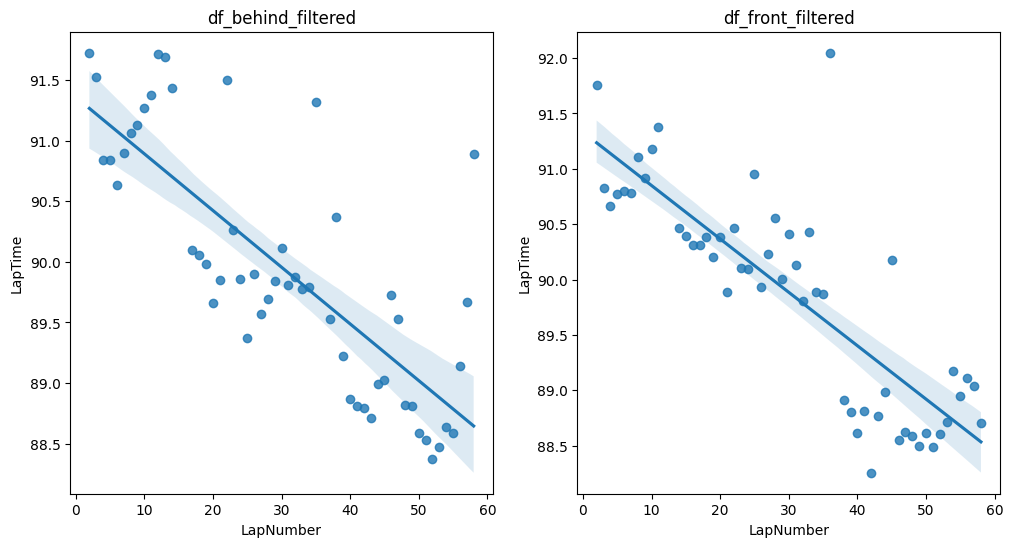

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot df_behind_filtered['LapTime'] and df_behind_filtered['LapTimeLag_1'] on the first subplot
sns.regplot(x='LapNumber', y='LapTime', data=df_behind, ax=ax1)
ax1.set_title('df_behind_filtered')

# Plot df_front_filtered['LapTime'] and df_front_filtered['LapTimeLag_1'] on the second subplot
sns.regplot(x='LapNumber', y='LapTime', data=df_front, ax=ax2)
ax2.set_title('df_front_filtered')

# Display the plots
plt.show()

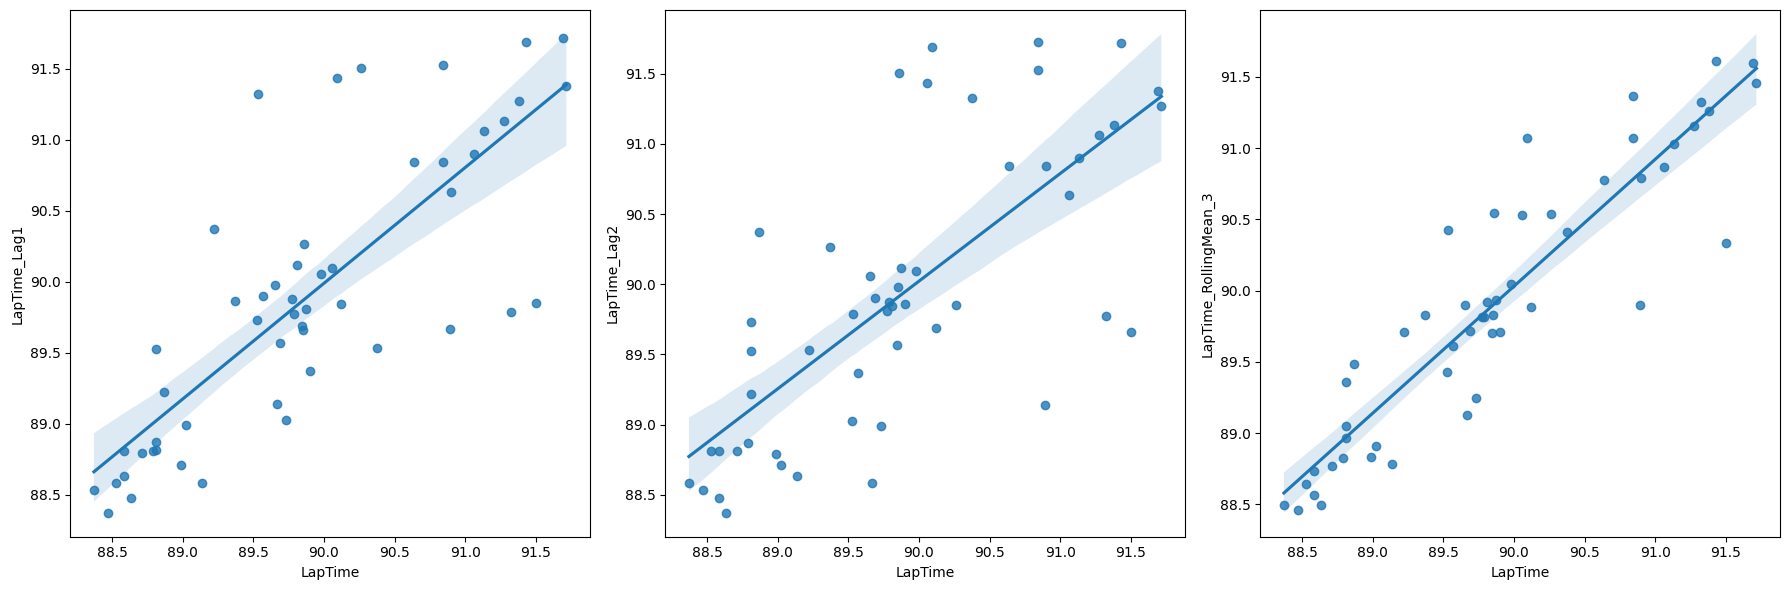

In [79]:
df_behind = df_behind.dropna(subset=['LapTime', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_RollingMean_3'])
# Create a 1x3 grid of subplots
# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# List of columns to plot against 'LapTime'
columns = ['LapTime_Lag1', 'LapTime_Lag2', 'LapTime_RollingMean_3']

# Create the plots
for i, col in enumerate(columns):
    ax = axs[i]
    sns.regplot(x='LapTime', y=col, data=df_behind, ax=ax)

    

# Display the plots
plt.tight_layout()
plt.show()

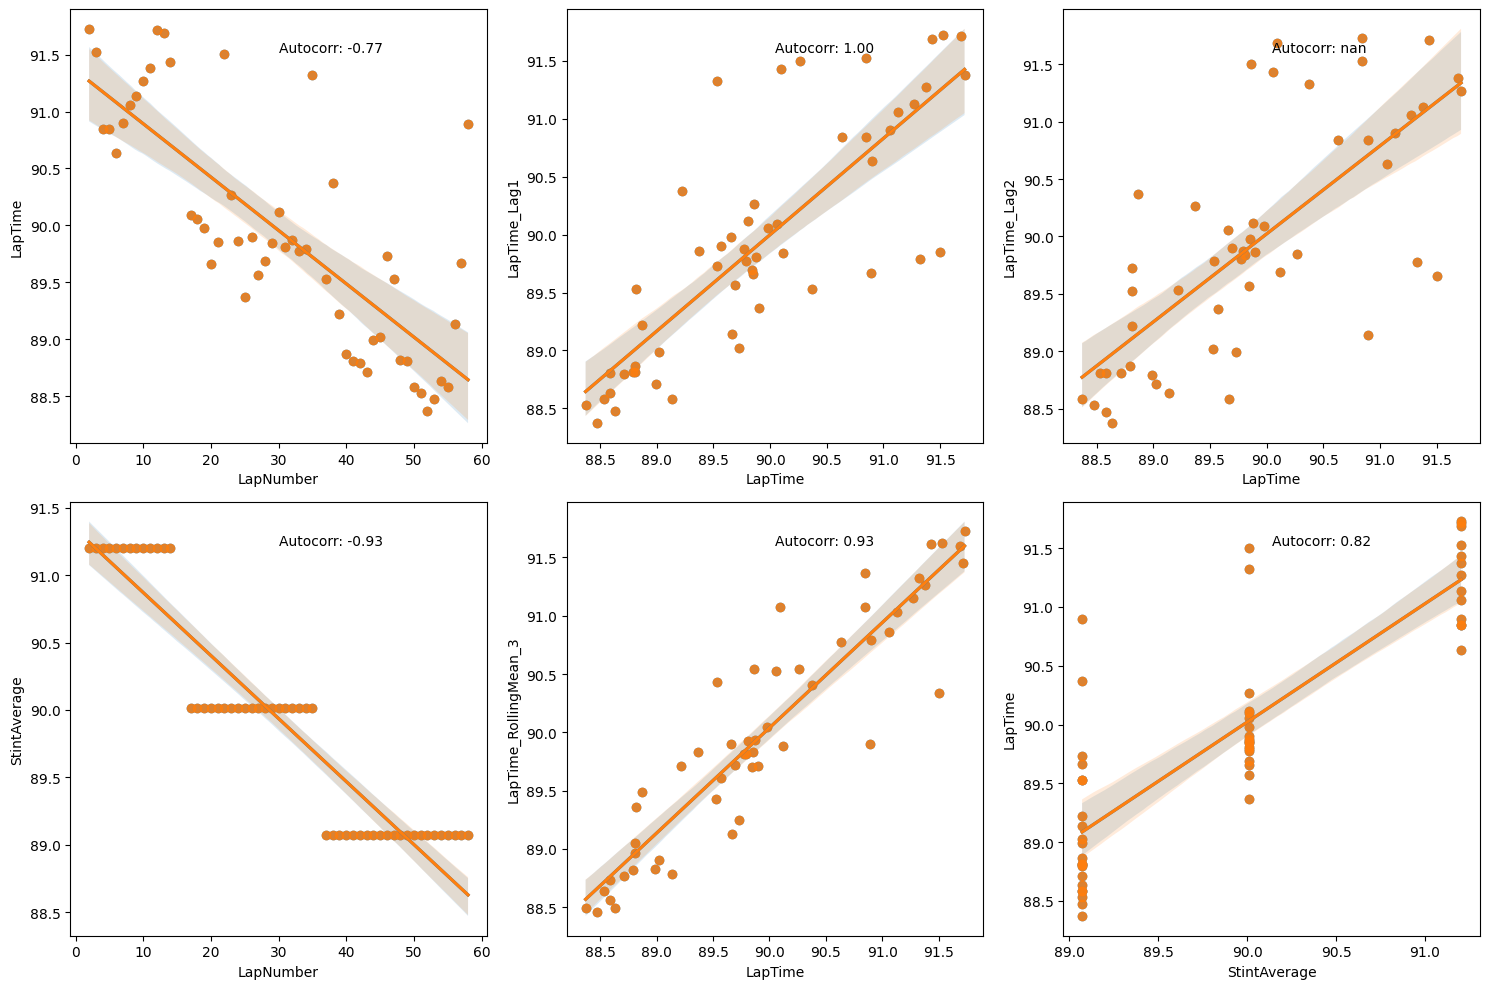

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Create the plots
sns.regplot(x='LapNumber', y='LapTime', data=df_behind, ax=axs[0, 0])
sns.regplot(x='LapTime', y='LapTime_Lag1', data=df_behind, ax=axs[0, 1])
sns.regplot(x='LapTime', y='LapTime_Lag2', data=df_behind, ax=axs[0, 2])
sns.regplot(x='LapNumber', y='StintAverage', data=df_behind, ax=axs[1, 0])
sns.regplot(x='LapTime', y='LapTime_RollingMean_3', data=df_behind, ax=axs[1, 1])
sns.regplot(x='StintAverage', y='LapTime', data=df_behind, ax=axs[1, 2])

import numpy as np

# Create the plots
for i, (x, y) in enumerate([('LapNumber', 'LapTime'), ('LapTime', 'LapTime_Lag1'), ('LapTime', 'LapTime_Lag2'), 
                            ('LapNumber', 'StintAverage'), ('LapTime', 'LapTime_RollingMean_3'), ('StintAverage', 'LapTime')]):
    ax = axs[i//3, i%3]
    sns.regplot(x=x, y=y, data=df_behind, ax=ax)
    
    # Calculate the autocorrelation
    autocorr = np.corrcoef(df_behind[x].values[:-1], df_behind[y].values[1:])[0, 1]
    
    # Display the autocorrelation value on the plot
    ax.text(0.5, 0.9, f'Autocorr: {autocorr:.2f}', transform=ax.transAxes)

# Display the plots
plt.tight_layout()
plt.show()

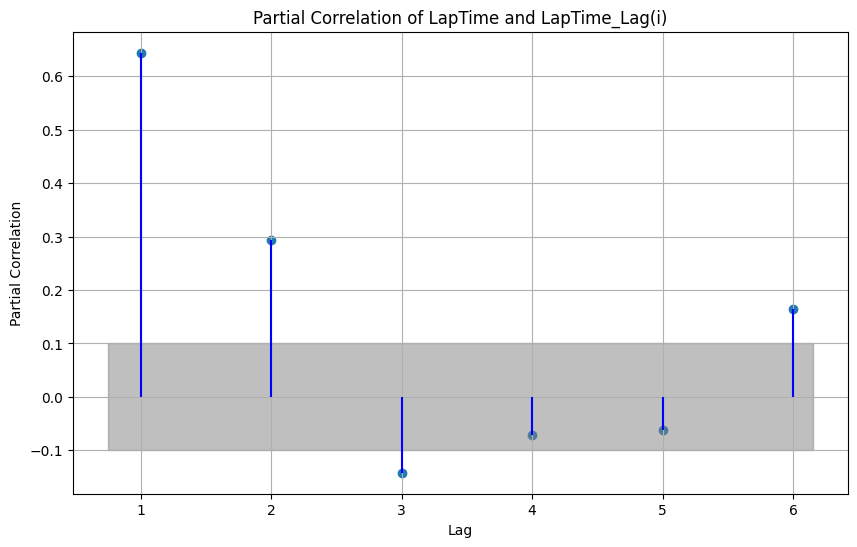

In [38]:
import statsmodels.api as sm
# Drop rows with NaN values from the entire DataFrame
df_behind_clean = df_behind[['LapTime', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_Lag3', 'LapTime_Lag4', 'LapTime_Lag5', 'LapTime_Lag6']].dropna()


# Initialize a list to store the partial correlations
partial_corrs = []

# Calculate the partial correlation for each lag
for i in range(1, 7):
    # Define the control variables
    control_vars = df_behind_clean.columns.difference(['LapTime', f'LapTime_Lag{i}']).tolist()
    
    # Fit the model
    model = sm.OLS(df_behind_clean['LapTime'], sm.add_constant(df_behind_clean[control_vars + [f'LapTime_Lag{i}']]))
    results = model.fit()
    
    # Get the partial correlation (which is the coefficient of 'LapTime_Lag(i)' in the model)
    partial_corr = results.params[f'LapTime_Lag{i}']
    partial_corrs.append(partial_corr)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(range(1, 7), partial_corrs, marker='o')
plt.xlabel('Lag')
plt.ylabel('Partial Correlation')
plt.title('Partial Correlation of LapTime and LapTime_Lag(i)')
plt.grid(True)

# Get the limits of the x-axis
x_start, x_end = plt.xlim()

# Fill the area between 0.1 and -0.1
plt.fill_between(np.arange(x_start, x_end, 0.1), -0.1, 0.1, color='gray', alpha=0.5)

# Add vertical lines from the points to the x-axis
for i in range(1, 7):
    plt.vlines(i, 0, partial_corrs[i-1], color='blue')

plt.show()

<h2>A parciális korreláció plot alapján eldönthető, hogy hány Lag Feature-t érdemes használni a modellekben. Jelen esetben a Lag6 feature hamis pozitívnak tekinthető.</h2>

In [14]:
def regression_model_fit(train_data, features, target):
    columns = features + [target]
    # Select the columns from train_data
    train_data = train_data[columns].dropna()

    X = train_data[features]
    y = train_data[target]

    model = LinearRegression()
    model.fit(X, y)

    return model

In [15]:
def regression_model_predict(model, X_test, features):
    
    X = X_test[features]
    predictions = model.predict(X)
    
    return predictions

In [ ]:
feature_set = ['LapTime', 'LapNumber', 'Stint',
       'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2',
       'SpeedFL', 'SpeedST', 'Compound', 'TyreLife',
       'FreshTyre', 'Team', 'CumulativeTime',
        'PitIn', 'PitOut', 'LapTime_Lag1',
       'LapTime_Lag2',  'LapTime_Lag3', 'LapTime_RollingMean_3',
       'StintAverage']

In [61]:
target = 'LapTime'
feat1 = ['LapNumber']
feat2 = ['LapNumber', 'TyreLife', 'Compound'] # this was excluded from the feature test
feat3 = ['LapNumber', 'LapTime_Lag1', 'LapTime_RollingMean_3']
feat4 = ['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_RollingMean_3']  # lets call this the winner mate
feat5 = ['LapNumber', 'LapTime_Lag1', 'LapTime_RollingMean_3', 'Team']
feat6 = ['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_Lag3'] # worst!!
feat7 = ['LapNumber', 'LapTime_Lag1', 'LapTime_RollingMean_3'] #top3
feat8 = ['LapNumber', 'LapTime_RollingMean_3']                #top3
feat9 = ['LapNumber', 'LapTime_Lag1','LapTime_RollingMean_3', 'TyreLife'] #top3
feature_sets = [feat1, feat2, feat3, feat4, feat5, feat6, feat7, feat8, feat9]

In [16]:
def prediction_context(df_race, driver_behind, driver_front, current_lap, num_lap_predict):
    df_race = add_lags(df_race, 3)
    df_race = add_rolling_mean(df_race)
    df_race = add_stint_mean(df_race)

    df_train, df_test = train_test_split(df_race, current_lap)
    df_test, _ = train_test_split(df_test, current_lap + num_lap_predict )

    
    train_behind, train_front = driver_split(df_train, driver_behind, driver_front)
    test_behind, test_front = driver_split(df_test, driver_behind, driver_front)

    return train_behind, train_front, test_behind, test_front

In [61]:
train_behind, train_front, test_behind, test_front = prediction_context(df_race, 'HAM', 'PIA', 54, 3)

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_16385/3286590795.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['Year', 'RaceName', 'Driver']).apply(custom_rolling)


In [32]:
def predict_lap_times(model, df_driver, num_future_laps):

    predictions = []

    last_row = df_driver.iloc[-1]
    features = df_driver[['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_RollingMean_3']].iloc[-1]
    features['LapTime_RollingMean_3'] = (last_row['LapTime'] + features['LapTime_Lag1'] + features['LapTime_Lag2']) / 3
    features['LapTime_Lag2'] = features['LapTime_Lag1']
    features['LapTime_Lag1'] = last_row['LapTime']
    features['LapNumber'] += 1 

    for i in range(num_future_laps):
        # Update features for the prediction
        lap_features = features.copy()
        lap_features = lap_features.values.reshape(1, -1)  # Reshape for single prediction

        # Predict the next lap time
        next_lap_time = model.predict(lap_features)[0]
        predictions.append(next_lap_time)

        # Update features for the next lap
        features['LapTime_RollingMean_3'] = (next_lap_time + features['LapTime_Lag1'] + features['LapTime_Lag2']) / 3
        features['LapTime_Lag2'] = features['LapTime_Lag1']
        features['LapTime_Lag1'] = next_lap_time
        features['LapNumber'] += 1  # Increment lap number
    
    return predictions

In [18]:

def train_and_evaluate(train_data, test_data, n_laps_predict, target='LapTime', features=['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_RollingMean_3']):
    # Train the model
    model = regression_model_fit(train_data, features, target)
    #### Use custom function to predict !!!
    predictions = predict_lap_times(model, train_data, n_laps_predict)
    #predictions = regression_model_predict(model, train_data, 5) # not the name of the function

    
    # Calculate the metrics
    mae = mean_absolute_error(test_data[target], predictions)
    mse = mean_squared_error(test_data[target], predictions)
    
    # Create a DataFrame for the results
    result_df = pd.DataFrame({
        'mae': [mae],
        'mse': [mse]
    })

    return predictions, result_df


In [20]:
df_race = filter_for_race(df_all, 'Austrian Grand Prix', 2023, team_encode=True)
df_race = remove_slow_laps(df_race)
train_behind, train_front, test_behind, test_front = prediction_context(df_race, 'PER', 'ALO', 39, 5)
behind_times, behind_accuracy = train_and_evaluate(train_behind, test_behind, 5)
front_times, front_accuracy = train_and_evaluate(train_front, test_front, 5)
behind_accuracy


/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_25134/3447590014.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_25134/3447590014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_25134/3286590795.py:13: DeprecationWarning: DataFrameGroupBy.apply 

,mae,mse
0,0.259,0.115


In [21]:
front_accuracy

,mae,mse
0,0.245,0.141


In [ ]:
[89.84200000000007,
 89.56799999999998,
 89.691,
 89.84200000000007,
 89.56799999999998]

#xgboost
[89.81228, 89.75693, 89.75325, 89.75325, 89.75325]


[90.00899999999997,
 90.22899999999997,
 90.5589999999999,
 90.009,
 90.22899999999994]

#xgboost
[90.26315, 90.32059, 90.341194, 90.2482, 90.2482]


3.232 # 0
3.065 # 1
2.405 # 2
1.537 # 3
1.37 # 4
0.709 # 5



In [63]:
def try_feature_sets(feature_sets, target, train_data, test_data):
    results = []

    for i, features in enumerate(feature_sets, 1):
        # Train and evaluate the model
        if train_data.empty or test_data.empty:
            continue
        result = train_and_evaluate(features, target, train_data, test_data)
        
        # Add the feature set number to the result
        result['feature_set'] = f'feat{i}'
        cols = list(result.columns)

        # Remove 'feature_set' from the list
        cols.remove('feature_set')

        # Reorder the columns to make 'feature_set' the first column
        result = result[['feature_set'] + cols]
        
        # Convert the result DataFrame to a dictionary and append it to the list of results
        results.append(result.to_dict('records')[0])

    # Convert the list of results to a DataFrame
    df_results = pd.DataFrame(results)

    return df_results

In [27]:
preds = pd.read_csv('AWS_battle_predictions_no_data_issue.csv')
preds = preds[(preds['Year'].isin([2018,2019,2020,2021])) & (preds['isVoided']==False)]
preds.columns


Index(['Year', 'RaceName', 'ChasingBehind', 'ChasingFront',
       'LeadLapofthePrediction', 'PredictedLaps', 'GapatPrediction',
       'Difficulty', 'isAccurate', 'isVoided', 'Error', 'gap_diff'],
      dtype='object')

In [73]:
def best_feature_set(df_all, preds, feature_sets, target):
    # Initialize an empty list to store the results
    all_results = []

    # Loop over the race scenarios in preds
    for _, race in preds.iterrows():
        # Filter the data for the current race
        df_race = filter_for_race(df_all, race['RaceName']+' Grand Prix', race['Year'], team_encode=True)
        df_race = remove_slow_laps(df_race)
        train_behind, train_front, test_behind, test_front = prediction_context(df_race, race['ChasingBehind'], race['ChasingFront'], race['LeadLapofthePrediction'], race['LeadLapofthePrediction']+race['PredictedLaps']+4)
        print(f'##################################### Race: {race['RaceName']} year : {race['Year']} #####################################')
        if(race['RaceName']=='Hungarian' and race['Year']==2020):
           continue
        if(race['RaceName']=='Turkish' and race['Year']==2020):
           continue
        # Check if the training and testing data are not empty
        if not train_behind.empty and not test_behind.empty:
            # Try the feature sets and get the results
            results_behind = try_feature_sets(feature_sets, target, train_behind, test_behind)
            results_behind['driver'] = 'behind'
            all_results.append(results_behind)

        if not train_front.empty and not test_front.empty:
            # Try the feature sets and get the results
            results_front = try_feature_sets(feature_sets, target, train_front, test_front)
            results_front['driver'] = 'front'
            all_results.append(results_front)

    # Check if all_results is empty
    if not all_results:
        print("No results to concatenate. Please check your data.")
        return pd.DataFrame()

    # Concatenate all the results into a single DataFrame
    df_results = pd.concat(all_results)

    # Calculate the average MAE and MSE
    df_results['avg_mae'] = df_results.groupby(['feature_set', 'driver'])['mae'].transform('mean')
    df_results['avg_mse'] = df_results.groupby(['feature_set', 'driver'])['mse'].transform('mean')

        # Convert lists to strings
    df_results = df_results.applymap(lambda x: str(x) if isinstance(x, list) else x)

    # Drop duplicates
    df_results = df_results.drop_duplicates()

    return df_results

In [ ]:
df_results = best_feature_set(df_all, preds, feature_sets, target)


In [ ]:
df_race = filter_for_race(df, race_name, year, team_encode=True)
df_race = remove_slow_laps(df_race)
train_behind, train_front, test_behind, test_front = prediction_context(df_race, driver_behind, driver_front, current_lap, num_lap_predict)
result_df = train_and_evaluate(features, target, train_data, test_data) # result for one race scenario and one feature set
try_feature_sets(feature_sets, target, train_data, test_data) # result for one race all (9) feature sets in df

In [86]:
df_results['avg_mae'] = df_results.groupby(['feature_set'])['mae'].transform('mean')
df_results['avg_mse'] = df_results.groupby(['feature_set'])['mse'].transform('mean')
df_results.drop(['feature_set','mae', 'mse'], axis=1, inplace=True)
df_results.head(8)

,features,avg_mae,avg_mse
0,['LapNumber'],0.839,1.508
1,"['LapNumber', 'LapTime_Lag1', 'LapTime_Rolling...",0.458,0.568
2,"['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', ...",0.107,0.175
3,"['LapNumber', 'LapTime_Lag1', 'LapTime_Rolling...",0.458,0.568
4,"['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', ...",0.820,2.121
5,"['LapNumber', 'LapTime_Lag1', 'LapTime_Rolling...",0.458,0.568
6,"['LapNumber', 'LapTime_RollingMean_3']",0.451,0.515
7,"['LapNumber', 'LapTime_Lag1', 'LapTime_Rolling...",0.432,0.461


In [84]:

df_results[df_results['feature_set']=='feat3']['features'].iloc[0]

"['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_RollingMean_3']"

In [88]:
##### WE have an updated one of this !!
def predict_lap_times(model, df_driver, num_future_laps):

    predictions = []
    features = df_driver[['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_RollingMean_3']].iloc[-1]

    for i in range(num_future_laps):
        # Update features for the prediction
        lap_features = features.copy()
        lap_features = lap_features.values.reshape(1, -1)  # Reshape for single prediction

        # Predict the next lap time
        next_lap_time = model.predict(lap_features)[0]
        predictions.append(next_lap_time)

        # Update features for the next lap
        features['LapTime_RollingMean_3'] = (next_lap_time + features['LapTime_Lag1'] + features['LapTime_Lag2']) / 3
        features['LapTime_Lag2'] = features['LapTime_Lag1']
        features['LapTime_Lag1'] = next_lap_time
        features['LapNumber'] += 1  # Increment lap number
    
    return predictions

In [166]:
df_race = filter_for_race(df_all, 'Mexico City Grand Prix', 2021, team_encode=True)
df_race = remove_slow_laps(df_race)
df_race = add_lags(df_race, 5)
df_race = add_rolling_mean(df_race, 3)
df_race = add_stint_mean(df_race)

cols = ['DriverNumber', 'LapTime', 'LapNumber', 'Stint', 
       'SpeedFL', 'Compound', 'TyreLife',
       'FreshTyre', 'Team', 'Position', 'LapTime_Lag1',
       'LapTime_Lag2',
        'LapTime_Lag3', 
        'LapTime_Lag4', 
       'LapTime_Lag5',  'LapTime_RollingMean_3',
       'StintAverage']
df = df_race[cols].dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 5 to 891
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DriverNumber           800 non-null    int64  
 1   LapTime                800 non-null    float64
 2   LapNumber              800 non-null    float64
 3   Stint                  800 non-null    float64
 4   SpeedFL                800 non-null    float64
 5   Compound               800 non-null    int64  
 6   TyreLife               800 non-null    float64
 7   FreshTyre              800 non-null    bool   
 8   Team                   800 non-null    int64  
 9   Position               800 non-null    float64
 10  LapTime_Lag1           800 non-null    float64
 11  LapTime_Lag2           800 non-null    float64
 12  LapTime_Lag3           800 non-null    float64
 13  LapTime_Lag4           800 non-null    float64
 14  LapTime_Lag5           800 non-null    float64
 15  LapTime_Rol

/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_17082/3447590014.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_17082/3447590014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_17082/3286590795.py:13: DeprecationWarning: DataFrameGroupBy.apply 

In [148]:
mi_scores_df = pd.DataFrame(columns=['Feature', 'Score'])

In [167]:
#import pandas as pd
from sklearn.feature_selection import mutual_info_regression
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler

# Load your data


# Assume 'Compound' and 'Team' are the categorical features to be encoded
#categorical_features = ['Compound', 'Team']

# Setup the preprocessor
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', StandardScaler(), ['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_Lag3', 'StintAverage']),  # Numeric features
#        ('cat', OneHotEncoder(), categorical_features)  # Categorical features
#    ])

# Apply preprocessing
#X = preprocessor.fit_transform(data.drop(['LapTime'], axis=1))
#y = data['LapTime']

X = df[cols].drop(['LapTime'], axis=1)
y = df['LapTime']

features = X.columns.tolist()

# Compute Mutual Information
mi_scores = mutual_info_regression(X, y)

# Get feature names after one-hot encoding
#feature_names = (['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_Lag3', 'StintAverage'] +
#                 list(preprocessor.named_transformers_['cat'].get_feature_names(categorical_features)))

# Create a Series for the scores
temp_df = pd.DataFrame({
    'Feature': features,
    'Score': mi_scores
})
mi_scores_df = pd.concat([mi_scores_df, temp_df], ignore_index=True)
# Print the scores
mi_scores_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Feature  144 non-null    object 
 1   Score    144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [168]:
# Calculate the mean MI score for each feature
mean_mi_scores = mi_scores_df.groupby('Feature')['Score'].mean().reset_index()
mean_mi_scores = mean_mi_scores.sort_values(by='Score', ascending=False)
# Print the mean MI scores
print(mean_mi_scores)

                  Feature  Score
9   LapTime_RollingMean_3  1.180
4            LapTime_Lag1  0.797
13           StintAverage  0.787
5            LapTime_Lag2  0.623
6            LapTime_Lag3  0.508
7            LapTime_Lag4  0.434
8            LapTime_Lag5  0.387
3               LapNumber  0.333
1            DriverNumber  0.298
10               Position  0.275
14                   Team  0.262
12                  Stint  0.219
11                SpeedFL  0.188
15               TyreLife  0.122
0                Compound  0.061
2               FreshTyre  0.028


In [22]:
xg_features = ['LapTime_RollingMean_3',
               'LapTime_Lag1',
               'StintAverage',
               'LapTime_Lag2',
               'LapTime_Lag3',
               'LapTime_Lag4',
               'LapTime_Lag5',
               'LapNumber',
               'Driver',
               'Position',
               'Team'
              ]

In [23]:
def get_xg_pipeline(colsample_bytree=0.5, learning_rate=0.3, max_depth=6, alpha=15, n_estimators=5000, min_child_weight=30):
    # Encoding categorical data
    categorical_feature = ['Driver']
    one_hot_encoder = OneHotEncoder()

    # Column transformer to apply transformations to the appropriate columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', one_hot_encoder, categorical_feature)],
        remainder='passthrough')

    # Initialize XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=colsample_bytree, learning_rate=learning_rate,
                            max_depth=max_depth, alpha=alpha, n_estimators=n_estimators, min_child_weight=min_child_weight)

    # Combine preprocessor and model into a pipeline
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('regressor', model)])

    return model_pipeline

colsample_bytree=0.7, learning_rate=0.04, max_depth=3, alpha=20, n_estimators=200
colsample_bytree=0.7, learning_rate=0.1, max_depth=4, alpha=20, n_estimators=300, min_child_weight=10
colsample_bytree=0.7, learning_rate=0.3, max_depth=5, alpha=10, n_estimators=1000
colsample_bytree=0.7, learning_rate=0.04, max_depth=3, alpha=20, n_estimators=200
colsample_bytree=0.7, learning_rate=0.04, max_depth=3, alpha=20, n_estimators=200
colsample_bytree=0.7, learning_rate=0.3, max_depth=5, alpha=10, n_estimators=1000
colsample_bytree=0.4, learning_rate=0.25, max_depth=8, alpha=10, n_estimators=12000

best yet:
colsample_bytree=0.5, learning_rate=0.3, max_depth=6, alpha=15, n_estimators=5000, min_child_weight=30

colsample_bytree=0.5, learning_rate=0.3, max_depth=6, alpha=15, n_estimators=5000, min_child_weight=30

In [24]:
def train_xg(df_race, features):
    # Define features and target variable
    X = df_race[features]
    y = df_race['LapTime']

    # Fit the model
    model_pipeline = get_xg_pipeline(colsample_bytree=0.8, learning_rate=0.2, max_depth=4, alpha=0, n_estimators=500, min_child_weight=1)
    model_pipeline.fit(X, y)

    return model_pipeline


In [37]:
def xg_predict(model_pipeline, df_race, xg_features, driver, num_future_laps):
    
    # Initialize feature set for the first prediction
    features = df_race.loc[df_race['Driver'] == driver].iloc[-1]  # Get the last record of selected driver
    predictions = []

    # A jelenlegi stint köridejei
    current_stint = features['Stint']
    stint_laptimes = df_race.loc[(df_race['Driver'] == driver) & (df_race['Stint'] == current_stint), 'LapTime']

    features['LapTime_Lag5'] = features['LapTime_Lag4']
    features['LapTime_Lag4'] = features['LapTime_Lag3']
    features['LapTime_Lag3'] = features['LapTime_Lag2']
    features['LapTime_Lag2'] = features['LapTime_Lag1']
    features['LapTime_Lag1'] = features['LapTime']
    features['LapNumber'] += 1

    for i in range(num_future_laps):
        # Update features for the prediction
        lap_features = pd.DataFrame([features], columns=features.index)
        lap_features = lap_features[xg_features]
        
        # Predict the next lap time
        next_lap_time = model_pipeline.predict(lap_features)[0]
        predictions.append(next_lap_time)

        # Update features for the next lap
        features['LapTime_RollingMean_3'] = (next_lap_time + features['LapTime_Lag1'] + features['LapTime_Lag2']) / 3
        features['LapTime_Lag5'] = features['LapTime_Lag4']
        features['LapTime_Lag4'] = features['LapTime_Lag3']
        features['LapTime_Lag3'] = features['LapTime_Lag2']
        features['LapTime_Lag2'] = features['LapTime_Lag1']
        features['LapTime_Lag1'] = next_lap_time
        features['LapNumber'] += 1

        # Update StintAverage
        stint_laptimes = pd.concat([stint_laptimes, pd.Series([next_lap_time])])
        features['StintAverage'] = stint_laptimes.mean()


    # Output predictions
    return predictions

In [26]:

def xg_train_and_evaluate(train_data, test_data, driver, n_laps_predict, target='LapTime', features=['LapNumber', 'LapTime_Lag1', 'LapTime_Lag2', 'LapTime_RollingMean_3']):
    # Train the model
    #model = regression_model_fit(train_data, features, target)
    #### Use custom function to predict !!!
    #predictions = predict_lap_times(model, train_data, 5)
    #predictions = regression_model_predict(model, train_data, 5) # not the name of the function
    
    model_pipeline = train_xg(train_data, xg_features)
    
    predictions = xg_predict(model_pipeline, train_data, xg_features, driver, n_laps_predict)
    
    # Calculate the metrics
    mae = mean_absolute_error(test_data[target], predictions)
    mse = mean_squared_error(test_data[target], predictions)
    
    # Create a DataFrame for the results
    result_df = pd.DataFrame({
        'mae': [mae],
        'mse': [mse]
    })

    return predictions, result_df


In [27]:
def xg_train_test_split(df_race, current_lap):
    df_race = remove_slow_laps(df_race)
    df_train, df_test = train_test_split(df_race, current_lap)
    #df_train = df_train[df_train['Driver'] == driver]
    df_test, _ = train_test_split(df_test, current_lap + 5)
    #df_test = df_test[df_test['Driver'] == driver]
    df_train = add_lags(df_train, 5)
    df_train = add_rolling_mean(df_train)
    df_train = add_stint_mean(df_train)

    return df_train, df_test

In [357]:
df_race = filter_for_race(df_all, 'Abu Dhabi Grand Prix', 2023, team_encode=True)
h_train_data, h_test_data = xg_train_test_split(df_race, 30, 'HAM')
p_train_data, p_test_data = xg_train_test_split(df_race, 30, 'ALO')


/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_20699/3447590014.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_20699/3447590014.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Team'] = filtered_df['Team'].replace(team_standings_map)
/var/folders/80/nwtb7gx54bg06b5y_lyjvwt40000gn/T/ipykernel_20699/2350675283.py:3: SettingWithCopyWarning: 
A value is trying t

In [366]:
preds, acc = xg_train_and_evaluate(h_train_data, h_test_data, 'HAM')
acc

,features,mae,mse
0,"[LapNumber, LapTime_Lag1, LapTime_Lag2, LapTim...",0.084,0.017


In [364]:
preds, acc = xg_train_and_evaluate(p_train_data, p_test_data, 'ALO')
acc

,features,mae,mse
0,"[LapNumber, LapTime_Lag1, LapTime_Lag2, LapTim...",0.232,0.067


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameters grid
param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'alpha': [10, 20],
    'n_estimators': [50, 100, 200]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)

# Fit GridSearchCV
grid_search.fit(X, y)

# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)


In [28]:
import itertools

def predict_striking_distance(lap_times_behind, lap_times_front, initial_gap):
    gap = initial_gap
    for i, (time_behind, time_front) in enumerate(zip(lap_times_behind, lap_times_front), start=1):
        gap += time_behind - time_front
        if gap < 1:
            return i
    return float('inf')

In [29]:
def average_predictions(model1, model2):
    return [(m1 + m2) / 2 for m1, m2 in zip(model1, model2)]

In [30]:
def evaluate_combined(test_data, predictions):
    mae = mean_absolute_error(test_data['LapTime'], predictions)
    mse = mean_squared_error(test_data['LapTime'], predictions)

    return pd.DataFrame({
        'mae': [mae],
        'mse': [mse]
    })

In [96]:
def battle_prediction(all_race_data, year, racename, driver_behind, driver_front, lap_of_race, n_laps_predict):
    # Verseny adatokra szűrés
    df_race = filter_for_race(all_race_data, racename, year, team_encode=True)

    #Lineáris Regresszió
    r_train_behind, r_train_front, test_behind, test_front = prediction_context(df_race.copy(), driver_behind, driver_front, lap_of_race, n_laps_predict)
    r_behind_times, r_behind_accuracy = train_and_evaluate(r_train_behind, test_behind, n_laps_predict)
    r_front_times, r_front_accuracy = train_and_evaluate(r_train_front, test_front, n_laps_predict)
    
    # XGBoost Regresszió
    train_data, _ = xg_train_test_split(df_race.copy(), lap_of_race)
    x_behind_times, x_behind_accuracy = xg_train_and_evaluate(train_data, test_behind, driver_behind, n_laps_predict)
    x_front_times, x_front_accuracy = xg_train_and_evaluate(train_data, test_front, driver_front, n_laps_predict)
    
    # Átlagolt predikciók
    combined_behind_times = average_predictions(r_behind_times, x_behind_times)
    combined_front_times = average_predictions(r_front_times, x_front_times)
    combined_behind_accuracy = evaluate_combined(test_behind, combined_behind_times)
    combined_front_accuracy = evaluate_combined(test_front, combined_front_times)

    # Két pilóta közötti távolság a predikció idején
    gap_between = r_train_behind['CumulativeTime'].iloc[-1] - r_train_front['CumulativeTime'].iloc[-1]
    
    # Támadási távolság kialakulásának kiszámítása
    regression_predicted_laps = predict_striking_distance(r_behind_times, r_front_times, gap_between)
    xgboost_predicted_laps = predict_striking_distance(x_behind_times, x_front_times, gap_between)
    combined_predicted_laps = predict_striking_distance(combined_behind_times, combined_front_times, gap_between)
    
    result_df = pd.DataFrame({
        'Year' : [year],
        'RaceName' : [racename],
        'ChasingBehind' : [driver_behind],
        'ChasingFront' : [driver_front],
        'LeadLapofthePrediction' : [lap_of_race],
        'RegressionPredictedLaps' : [regression_predicted_laps],
        'Regression_mae' : [(r_behind_accuracy['mae'].values[0] + r_front_accuracy['mae'].values[0]) / 2],
        'Regression_mse' : [(r_behind_accuracy['mse'].values[0] + r_front_accuracy['mse'].values[0]) / 2],
        'XGBoostPredictedLaps' : [xgboost_predicted_laps],
        'XGB_mae' : [(x_behind_accuracy['mae'].values[0] + x_front_accuracy['mae'].values[0]) / 2],
        'XGB_mse' : [(x_behind_accuracy['mse'].values[0] + x_front_accuracy['mse'].values[0]) / 2],
        'CombinedPredictedLaps' : [combined_predicted_laps],
        'Combined_mae' : [(combined_behind_accuracy['mae'].values[0] + combined_front_accuracy['mae'].values[0]) / 2],
        'Combined_mse' : [(combined_behind_accuracy['mse'].values[0] + combined_front_accuracy['mse'].values[0]) / 2]
    })

    return result_df


In [97]:
def battle_prediction(all_race_data, year, racename, driver_behind, driver_front, lap_of_race, n_laps_predict):
    # Verseny adatokra szűrés
    df_race = filter_for_race(all_race_data, racename, year, team_encode=True)
    df_race = remove_slow_laps(df_race)

    #Lineáris Regresszió
    r_train_behind, r_train_front, test_behind, test_front = prediction_context(df_race.copy(), driver_behind, driver_front, lap_of_race, n_laps_predict)
    r_behind_times, r_behind_accuracy = train_and_evaluate(r_train_behind, test_behind, n_laps_predict)
    r_front_times, r_front_accuracy = train_and_evaluate(r_train_front, test_front, n_laps_predict)
    
    # XGBoost
    train_data, _ = xg_train_test_split(df_race.copy(), lap_of_race)
    xbtrain = train_data[train_data['Driver']==driver_behind]
    xftrain = train_data[train_data['Driver']==driver_front]
    x_behind_times, x_behind_accuracy = xg_train_and_evaluate(xbtrain, test_behind, driver_behind, n_laps_predict)
    x_front_times, x_front_accuracy = xg_train_and_evaluate(xftrain, test_front, driver_front, n_laps_predict)
    
    # Átlagolt predikciók
    combined_behind_times = average_predictions(r_behind_times, x_behind_times)
    combined_front_times = average_predictions(r_front_times, x_front_times)
    combined_behind_accuracy = evaluate_combined(test_behind, combined_behind_times)
    combined_front_accuracy = evaluate_combined(test_front, combined_front_times)

    # Két pilóta közötti távolság a predikció idején
    gap_between = r_train_behind['CumulativeTime'].iloc[-1] - r_train_front['CumulativeTime'].iloc[-1]
    print("Gap: ")
    print(gap_between)
    
    # Támadási távolság kialakulásának kiszámítása
    regression_predicted_laps = predict_striking_distance(r_behind_times, r_front_times, gap_between)
    xgboost_predicted_laps = predict_striking_distance(x_behind_times, x_front_times, gap_between)
    combined_predicted_laps = predict_striking_distance(combined_behind_times, combined_front_times, gap_between)
    
    result_df = pd.DataFrame({
        'Year' : [year],
        'RaceName' : [racename],
        'ChasingBehind' : [driver_behind],
        'ChasingFront' : [driver_front],
        'LeadLapofthePrediction' : [lap_of_race],
        'RegressionPredictedLaps' : [regression_predicted_laps],
        'Regression_mae' : [(r_behind_accuracy['mae'].values[0] + r_front_accuracy['mae'].values[0]) / 2],
        'Regression_mse' : [(r_behind_accuracy['mse'].values[0] + r_front_accuracy['mse'].values[0]) / 2],
        'XGBoostPredictedLaps' : [xgboost_predicted_laps],
        'XGB_mae' : [(x_behind_accuracy['mae'].values[0] + x_front_accuracy['mae'].values[0]) / 2],
        'XGB_mse' : [(x_behind_accuracy['mse'].values[0] + x_front_accuracy['mse'].values[0]) / 2],
        'CombinedPredictedLaps' : [combined_predicted_laps],
        'Combined_mae' : [(combined_behind_accuracy['mae'].values[0] + combined_front_accuracy['mae'].values[0]) / 2],
        'Combined_mse' : [(combined_behind_accuracy['mse'].values[0] + combined_front_accuracy['mse'].values[0]) / 2]
    })

    return result_df


In [100]:
test_df = battle_prediction(df_all, 2019, 'United States Grand Prix', 'BOT', 'HAM',45,10)
# 2023, 'Singapore Grand Prix', 'RUS', 'NOR',56, 5
# 2023, 'Austrian Grand Prix', 'VER', 'LEC', 31, 5
# 2021, 'Spanish Grand Prix' ,'HAM','VER',48,10
# 2021, 'French Grand Prix', 'VER', 'BOT',38,6

Gap: 
3.4279999999998836


In [101]:
test_df

,Year,RaceName,ChasingBehind,ChasingFront,LeadLapofthePrediction,RegressionPredictedLaps,Regression_mae,Regression_mse,XGBoostPredictedLaps,XGB_mae,XGB_mse,CombinedPredictedLaps,Combined_mae,Combined_mse
0,2019,United States Grand Prix,BOT,HAM,45,inf,0.655,0.692,9,0.697,0.766,inf,0.639,0.695


In [82]:
aws_battle_predictions = pd.read_csv('AWS_battle_predictions_no_data_issue.csv')
import warnings
warnings.filterwarnings('ignore')

In [92]:
# Filter the DataFrame
filtered_aws_battle_predictions = aws_battle_predictions[aws_battle_predictions['PredictedLaps'] <= 5]

# Get unique combinations of Year, RaceName, ChasingBehind, ChasingFront, and LeadLapofthePrediction
unique_combinations = filtered_aws_battle_predictions[['Year', 'RaceName', 'ChasingBehind', 'ChasingFront', 'LeadLapofthePrediction']].drop_duplicates()
unique_combinations = unique_combinations[~(((unique_combinations['Year'] == 2023) & 
                                             (unique_combinations['RaceName'] == 'Hungarian') & 
                                             (unique_combinations['ChasingBehind'] == 'RUS') & 
                                             (unique_combinations['ChasingFront'] == 'ALO') & 
                                             (unique_combinations['LeadLapofthePrediction'] == 42)) |
                                            ((unique_combinations['Year'] == 2023) & 
                                             (unique_combinations['RaceName'] == 'Brazil') & 
                                             (unique_combinations['ChasingBehind'] == 'PER') & 
                                             (unique_combinations['ChasingFront'] == 'ALO') & 
                                             (unique_combinations['LeadLapofthePrediction'] == 32)) |
                                            ((unique_combinations['Year'] == 2023) & 
                                             (unique_combinations['RaceName'] == 'Spanish') & 
                                             (unique_combinations['ChasingBehind'] == 'RUS') & 
                                             (unique_combinations['ChasingFront'] == 'SAI') & 
                                             (unique_combinations['LeadLapofthePrediction'] == 33)) |
                                            ((unique_combinations['Year'] == 2023) & 
                                             (unique_combinations['RaceName'] == 'Bahrain') & 
                                             (unique_combinations['ChasingBehind'] == 'ALO') & 
                                             (unique_combinations['ChasingFront'] == 'SAI') & 
                                             (unique_combinations['LeadLapofthePrediction'] == 40)))]
# Initialize an empty DataFrame to store the results
last_own_battle_predictions = pd.DataFrame()

# Loop over the unique combinations and call the battle_prediction function for each one
for row in unique_combinations.itertuples(index=False):
    year, race_name, chasing_behind, chasing_front, lead_lap = row
    print(year, race_name, chasing_behind, chasing_front, lead_lap)
    try:
        battle_pred_df = battle_prediction(df_all, year, race_name + ' Grand Prix', chasing_behind, chasing_front, lead_lap, 20)
        # Concatenate the result to the own_battle_predictions DataFrame
        last_own_battle_predictions = pd.concat([last_own_battle_predictions, battle_pred_df], ignore_index=True)
    except ValueError as e:
        print(f"Error occurred: {e}. Skipping this combination.")

2023 Hungarian HAM PIA 54
2023 Hungarian PER HAM 33
2023 Abu Dhabi HAM ALO 30
2023 Miami HAM LEC 50
2023 Austrian VER LEC 31
2023 Austrian PER ALO 39
2023 Singapore RUS NOR 56
2022 Miami HAM BOT 36
2022 Spanish SAI BOT 53
2022 Spanish VER RUS 33
2022 Azerbaijan HAM GAS 33
2022 Canadian ALO LEC 38
2022 Canadian RUS ALO 27
2022 Austrian SAI VER 36
2022 French SAI NOR 45
2022 Hungarian HAM SAI 58
2022 Hungarian HAM SAI 46
2022 Dutch HAM PER 34
2022 Dutch VER RUS 23
2022 São Paulo HAM PER 39
2022 São Paulo HAM SAI 33
2021 Portuguese BOT VER 45
2021 French VER BOT 38
2021 Styrian PER BOT 39
2021 Austrian NOR BOT 52
2021 Austrian BOT HAM 42
2021 Dutch NOR OCO 51
2021 Dutch VER BOT 25
2021 Russian HAM NOR 33
2021 Turkish HAM PER 22
2021 Mexico City PER HAM 57
2020 Styrian BOT VER 65
2020 Styrian BOT VER 24
2020 Hungarian BOT VER 40
2020 Hungarian BOT STR 23
2020 Hungarian BOT STR 13
Error occurred: Found array with 0 sample(s) (shape=(0, 4)) while a minimum of 1 is required by LinearRegressio

In [86]:
print("Average Regression MAE:", own_battle_predictions['Regression_mae'].mean())
print("Average Regression MSE:", own_battle_predictions['Regression_mse'].mean())
print("Average XGB MAE:", own_battle_predictions['XGB_mae'].mean())
print("Average XGB MSE:", own_battle_predictions['XGB_mse'].mean())
print("Average Combined MAE:", own_battle_predictions['Combined_mae'].mean())
print("Average Combined MSE:", own_battle_predictions['Combined_mse'].mean())

Average Regression MAE: 0.40967450112437975
Average Regression MSE: 0.36400641198288336
Average XGB MAE: 0.43427611231310576
Average XGB MSE: 0.4176122059668495
Average Combined MAE: 0.4004509401489473
Average Combined MSE: 0.35298254933269213


In [81]:
own_battle_predictions.to_csv('own_battle_predictions.csv', index=False)

In [ ]:
filtered_aws_battle_predictions.info()

In [93]:
last_own_battle_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     45 non-null     int64  
 1   RaceName                 45 non-null     object 
 2   ChasingBehind            45 non-null     object 
 3   ChasingFront             45 non-null     object 
 4   LeadLapofthePrediction   45 non-null     int64  
 5   RegressionPredictedLaps  45 non-null     float64
 6   XGBoostPredictedLaps     45 non-null     float64
 7   CombinedPredictedLaps    45 non-null     float64
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ KB


In [95]:
last_own_battle_predictions.to_csv('last_own_battle_predictions.csv', index=False)